### Stochastic gradient MCMC:

In [1]:
from __future__ import division
get_ipython().magic('matplotlib inline')
import numpy as np, matplotlib.pyplot as plt, math, numpy.random as npr, torch
from pylab import plot, show, legend
from time import time
from tqdm import trange

In [2]:
y = np.load('/xtmp/DC-BATS_data/ar(2)_errors/y.npy')
X = np.load('/xtmp/DC-BATS_data/ar(2)_errors/X.npy')
beta_true = np.load('/xtmp/DC-BATS_data/ar(2)_errors/beta.npy')
X = X.transpose()

T = len(y)
p = len(beta_true)

y, X = torch.tensor(y), torch.tensor(X)

sigmasq = (torch.tensor([1.], requires_grad=True)).double()
phi = (torch.tensor([-1.,1.], requires_grad=True)).double()
beta = (torch.randn(1,p)/2).double().requires_grad_()
alpha = (torch.tensor([0.5], requires_grad=True)).double()

In [3]:
T

100000

In [4]:
def loglikelihood(y, X, alpha, beta, phi, sigmasq) : 
    assert len(y) >= 3, "chunk not long enough"
    assert len(y) == np.shape(X)[1], "dimensions of y and X do not match"
    return torch.sum((y[0:2] - alpha - torch.matmul(beta,X[:,0:2]))**2)/(2*sigmasq) \
     + torch.sum((y[2:-1] - (alpha + torch.matmul(beta,X[:,2:-1]) \
                        + phi[0]*(y[1:-2] - alpha - torch.matmul(beta,X[:,1:-2])) \
                        + phi[1]*(y[0:-3] - alpha - torch.matmul(beta,X[:,0:-3]))))**2)/(2*sigmasq)
    
def log_pr_beta(beta, pr_mu=0, pr_sigmasq=100) :
    return torch.sum((beta-pr_mu)**2/(2*pr_sigmasq))

def log_pr_alpha(alpha, pr_mu=0, pr_sigmasq=100) :
    return (alpha-pr_mu)**2/(2*pr_sigmasq)

def log_pr_phi(phi, pr_mu=0, pr_sigmasq=100) :
    return torch.sum((phi-pr_mu)**2/(2*pr_sigmasq))

def log_pr_sigmasq(sigmasq, pr_a=3, pr_b=10) :
    return (pr_a+1)/sigmasq - pr_b/sigmasq**2

In [5]:
def SGLD(y, X, beta_init, alpha_init, sigmasq_init, phi_init, stepsize, n_mcmc, chunk_len) :
    p = beta_init.size()[-1]
    beta_mcmc = torch.zeros((n_mcmc+1,p)).double()
    alpha_mcmc = torch.zeros(n_mcmc+1).double()
    phi_mcmc = torch.zeros((n_mcmc+1,2)).double()
    sigmasq_mcmc = torch.zeros(n_mcmc+1).double()

    beta_mcmc[0] = beta_init.detach()
    alpha_mcmc[0] = alpha_init.detach()
    phi_mcmc[0] = phi_init.detach()
    sigmasq_mcmc[0] = sigmasq_init.detach()

    beta = beta_init.detach().requires_grad_()
    alpha = alpha_init.detach().requires_grad_()
    sigmasq = sigmasq_init.detach().requires_grad_()
    phi = phi_init.detach().requires_grad_()

    sqss = np.sqrt(stepsize)
    T = len(y)
    
    for i in trange(n_mcmc) :
        
        start = npr.randint(T-chunk_len+1)
        stop = start + chunk_len
        target = -(T/chunk_len*loglikelihood(y[start:stop], X[:,start:stop], alpha, beta, phi, sigmasq) \
                    + log_pr_beta(beta) + log_pr_alpha(alpha) + log_pr_phi(phi) + log_pr_sigmasq(sigmasq))
        target.backward()

        # do SGLD step
        beta = (beta.detach() + stepsize/2*beta.grad + sqss*torch.randn(1,p).double()).requires_grad_()
        alpha = (alpha.detach() + stepsize/2*alpha.grad + sqss*torch.randn(1).double()).requires_grad_()
        sigmasq = (sigmasq.detach() + stepsize/2*sigmasq.grad + sqss*torch.randn(1).double()).requires_grad_()
        phi = (phi.detach() + stepsize/2*phi.grad + sqss*torch.randn(2).double()).requires_grad_()

        beta_mcmc[i+1] = beta.detach()
        alpha_mcmc[i+1] = alpha.detach()
        sigmasq_mcmc[i+1] = sigmasq.detach()
        phi_mcmc[i+1] = phi.detach()
        
    return beta_mcmc, alpha_mcmc, sigmasq_mcmc, phi_mcmc

In [17]:
beta_mcmc, alpha_mcmc, sigmasq_mcmc, phi_mcmc = SGLD(y, X, beta, alpha, sigmasq, phi, 
                                                     stepsize=2e-6, n_mcmc=10_000, chunk_len=1_000)

100%|██████████| 10000/10000 [00:10<00:00, 996.24it/s]


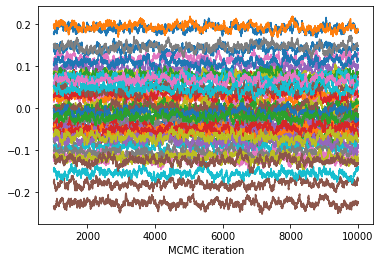

In [18]:
burn_in = 1000
n_mcmc = np.shape(beta_mcmc)[0]
for i in range(p) :
    plt.plot(np.arange(burn_in,n_mcmc), beta_mcmc[burn_in:,i].numpy())
plt.xlabel("MCMC iteration");

In [19]:
np.linalg.norm(beta_true-np.mean(beta_mcmc[burn_in:].numpy(),0))

0.018416610014192657

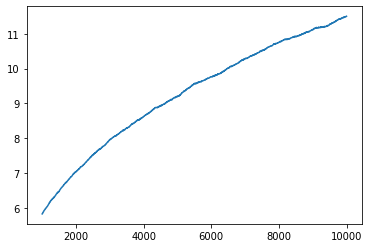

In [20]:
plt.plot(np.arange(burn_in,n_mcmc), sigmasq_mcmc[burn_in:].numpy())

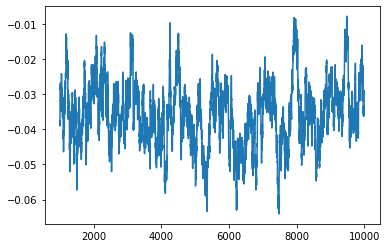

In [21]:
i = 10
plt.plot(np.arange(burn_in,n_mcmc), beta_mcmc[burn_in:,i].numpy())

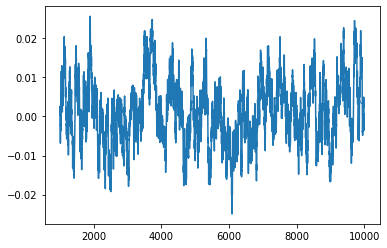

In [22]:
plt.plot(np.arange(burn_in,n_mcmc), alpha_mcmc[burn_in:].numpy())

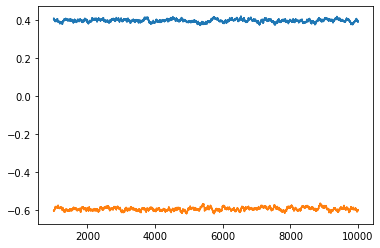

In [23]:
for i in range(2) :
    plt.plot(np.arange(burn_in,n_mcmc), phi_mcmc[burn_in:,i].numpy())

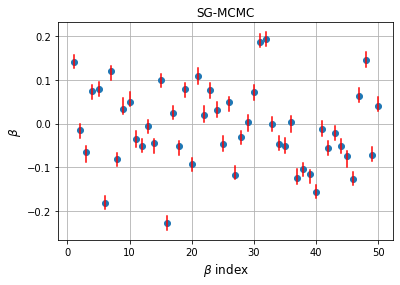

In [24]:
CI = np.percentile(beta_mcmc[burn_in:].numpy(), q=[2.5,97.5], axis=0)
plt.plot(np.arange(1,p+1), beta_true, "o")
for i in range(p) :
    plt.plot([i+1,i+1], CI[:,i], "r-")
plt.grid(True)
plt.xlabel(r"$\beta$ index", fontsize=12)
plt.ylabel(r"$\beta$", fontsize=12)
plt.title("SG-MCMC");

In [25]:
np.mean(CI[1]-CI[0])

0.03214121075163795